In [16]:
from pymed import PubMed
from concurrent.futures import ThreadPoolExecutor
import time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pubmed = PubMed(tool="MyTool", email="b.mascat@gmail.com")
drugs = pd.read_csv("../data/drugs.csv", header=None, names=['drug'])
tumors = pd.read_csv("../data/tumors.csv", header=None, names=['tumor'])

# Function to get the number of results from pubmed
def get_results_count(query):
    return pubmed.getTotalResultsCount(query)

# Function to process a single combination of diseases and drugs
def process_combination(disease, drug):
    query = f"{disease} AND {drug}"
    results_count = get_results_count(query)
    return {f'{disease.columns[0]}': disease, f'{drug.colums[0]}': drug, 'results': results_count}



In [3]:
# Data preprocessing function

def data_preprocessing(results_df, rows = "drug", columns = "term", cellValues = "count", num_top_events = 12):
    # Data preprocessing

    # We use the pivot_table function (handles duplicates) to convert the long DataFrame to a wide one
    results_df_wide = results_df.pivot_table(index=rows, columns=columns, values=cellValues)

    # We remove the drug label as column name
    results_df_wide.columns.name = None

    # We reset the indices so that the tumor type and the drug names are at the same level
    results_df_wide.reset_index(inplace=True)

    # We extract the 12 events with the highest number of results in the bibliography. Independently of the tumor type 
    top_events = results_df_wide.drop(columns=[rows]).sum().sort_values(ascending=False).head(num_top_events)

    # We filter the dataframe to keep only the tumor type column and the drugs with the most results
    results_df_wide = results_df_wide[[rows] + list(top_events.index)]

    # We define the tumor type as the indices of the dataframe
    results_df_wide.set_index(rows, inplace=True)

    # Sum the total of results of the 15 drugs for each tumor type and create a new column called 'TotalResults'
    results_df_wide['TotalResults'] = results_df_wide[list(top_events.index)].sum(axis=1)

    # Sort the DataFrame by the new column 'TotalResults' in descending order
    results_df_wide = results_df_wide.sort_values(by='TotalResults', ascending=False).reset_index()
    results_df_wide = results_df_wide[[rows] + list(top_events.index)]
    results_df_wide.set_index(rows, inplace=True)

    results_df = results_df_wide.fillna(0)
    
    return results_df, top_events

def bar_plot_results(results_df_wide, top_events, num_columns = 25, xlab = 'Drugs', 
                     plot_title ='Drugs and adverse effects. Source:Faers', legend_title = 'Adverse effects'):
    # Visualize the results of each drug in function of the tumor type

    # Configure the unique color palette for each drug with Seaborn
    colors = sns.color_palette("Set3", n_colors=len(top_events))

    # Create a stacked bar plot
    ax = results_df_wide.head(num_columns).plot(kind='bar', stacked=True, figsize=(10, 6), color = colors, width=0.8)

    # Add labels and title
    ax.set_xlabel(xlab, fontsize=12)
    ax.set_ylabel('Number of Results', fontsize=12)
    ax.set_title(plot_title, fontsize=14)
    ax.legend(title= legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')  # Place the legend to the right
    plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels
    plt.tight_layout()  # Adjust the layout of the plot
    plt.show()
    
def iterative_pubmed_search(first_list, second_list):
    # Initialize a list to store the results
    results_list = []

    # Nested loop to combine tumor types and drugs
    for first_list_element in first_list[first_list.columns[0]]:
        for second_list_element in second_list[second_list.columns[0]]:
            # Create the query combining the tumor type and the drug
            query = f"{first_list_element} AND {second_list_element}"
            # Get the number of results
            results_count = get_results_count(query)
            # Add the results to the list
            results_list.append({f'{first_list.columns[0]}': first_list_element, f'{second_list.columns[0]}': second_list_element, 'results': results_count})

    # Create a DataFrame from the list of results
    results_df = pd.DataFrame(results_list)
    return results_df

def iterative_pubmed_search_papers(first_list, second_list):
    # Initialize a list to store the results
    results_list = []

    # Nested loop to combine tumor types and drugs
    for first_list_element in first_list[first_list.columns[0]]:
        for second_list_element in second_list[second_list.columns[0]]:
            # Create the query combining the tumor type and the drug
            query = f"{first_list_element} AND {second_list_element}"
            # Get the number of results
            results_count = pubmed.query(query, max_results=1)
            # Add the results to the list
            results_list.append({f'{first_list.columns[0]}': first_list_element, f'{second_list.columns[0]}': second_list_element, 'results': results_count})

    # Create a DataFrame from the list of results
    results_df = pd.DataFrame(results_list)
    return results_df
    

In [4]:
results_df = iterative_pubmed_search(tumors, drugs)

# Show the final DataFrame
print("DataFrame of Results:")
print(results_df)

DataFrame of Results:
                             tumors                  drugs  Results
0            Gastric Adenocarcinoma          pembrolizumab      152
1            Gastric Adenocarcinoma            osimertinib        5
2            Gastric Adenocarcinoma              nivolumab      167
3            Gastric Adenocarcinoma            abemaciclib        0
4            Gastric Adenocarcinoma  emtansine trastuzumab       12
...                             ...                    ...      ...
2555  Colorectal Carcinoma Invasive              alpelisib        2
2556  Colorectal Carcinoma Invasive              rucaparib        0
2557  Colorectal Carcinoma Invasive           temozolomide        4
2558  Colorectal Carcinoma Invasive            oxaliplatin      380
2559  Colorectal Carcinoma Invasive              sotorasib        2

[2560 rows x 3 columns]


In [5]:
# save results of the pubmed search in .csv
results_df.to_csv('../results/pubmed_results.csv', index=False)

In [ ]:
# Create a list of combinations of tumor types and drugs
combinations = [(tumor, drug) for tumor in tumors['tumors'] for drug in drugs['drugs']]

results_list = []
# Use ThreadPoolExecutor to process the combinations in parallel
with ThreadPoolExecutor() as executor:
    for combination in combinations:
        results_list.append(executor.submit(lambda x: process_combination(*x), combination).result())
        time.sleep(1)  # Esperar 1 segundo entre cada solicitud


# Create a DataFrame from the list of results
results_df = pd.DataFrame(results_list)

# Show the final DataFrame
print("DataFrame of Results:")
print(results_df)

In [8]:
results_df = pd.read_csv("../results/pubmed_results.csv")

In [9]:
# Preprocessing the dataframe 
results_df_wide, top_farmacos = data_preprocessing(results_df, rows = "tumor", columns = "drug", cellValues = "results", num_top_events = 12)

results_df_wide

,fluorouracil,gemcitabine,oxaliplatin,paclitaxel,irinotecan,capecitabine,doxorubicin,bevacizumab,trastuzumab,cetuximab,carboplatin,everolimus
tumor,,,,,,,,,,,,
Pancreatic Adenocarcinoma,2338.0,4231.0,920.0,1099.0,849.0,354.0,384.0,167.0,54.0,96.0,104.0,91.0
Gastric Adenocarcinoma,2640.0,134.0,741.0,611.0,369.0,479.0,578.0,97.0,492.0,45.0,124.0,23.0
Colorectal Adenocarcinoma,1997.0,84.0,868.0,85.0,589.0,390.0,212.0,405.0,39.0,302.0,56.0,13.0
Esophageal Squamous Cell Carcinoma,1677.0,30.0,76.0,538.0,88.0,57.0,116.0,18.0,37.0,70.0,215.0,7.0
Esophageal Adenocarcinoma,1027.0,47.0,297.0,363.0,148.0,203.0,172.0,71.0,223.0,52.0,191.0,11.0
Rectal Adenocarcinoma,1399.0,15.0,376.0,23.0,164.0,393.0,55.0,147.0,3.0,64.0,32.0,1.0
Colorectal Carcinoma Invasive,892.0,22.0,380.0,56.0,162.0,143.0,77.0,176.0,17.0,142.0,16.0,5.0
Pancreatic Neuroendocrine Tumor,242.0,56.0,48.0,29.0,43.0,151.0,79.0,66.0,5.0,6.0,45.0,483.0
Duodenal Adenocarcinoma,197.0,102.0,54.0,24.0,30.0,52.0,29.0,18.0,20.0,7.0,9.0,2.0


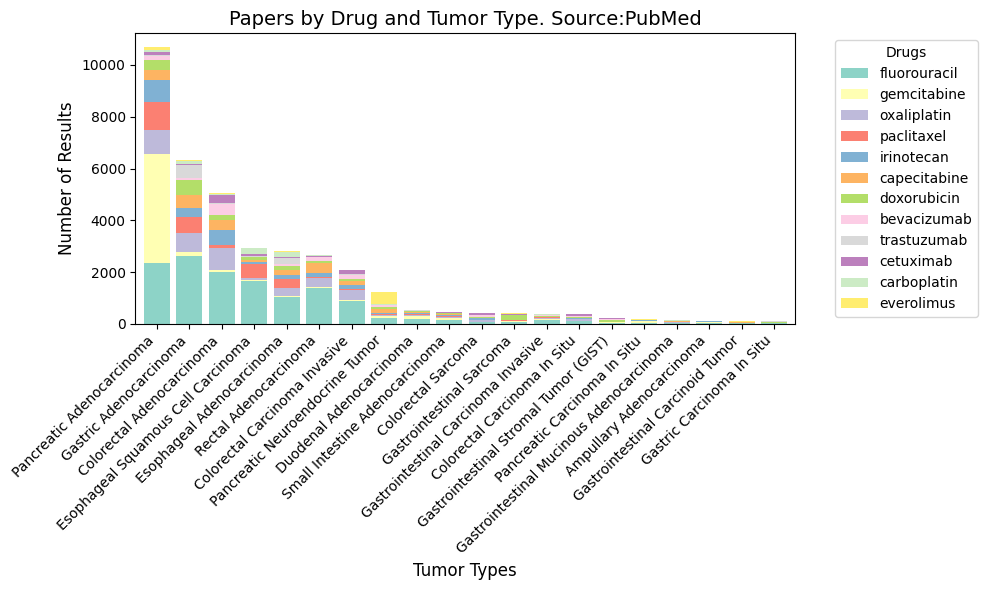

In [12]:
# Visualize the results of each drug in function of the tumor type

bar_plot_results(results_df_wide, top_farmacos, num_columns = 20, xlab = 'Tumor Types', 
                     plot_title ='Papers by Drug and Tumor Type. Source:PubMed', legend_title = 'Drugs')

In [17]:
# Initialize a list to store the results
results_list = []
adverse_effects = ["sarcopenia", "dysphagia"]

# Nested loop to combine adverse effect and drugs
for adverse_effect in adverse_effects:
    for drug in drugs['drug']:
        # Create the query combining the tumor type and the drug
        query = f"{adverse_effect} AND {drug}"
        # Get the number of results
        results_count = get_results_count(query)
        # Add the results to the list
        results_list.append({'adverse effect': adverse_effect, 'drug': drug, 'results': results_count})

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results_list)

In [18]:
# Save results of the pubmed search in .csv
results_df.to_csv('../results/results_pubmed_adverse_effects.csv', index=False)

In [19]:
# Load data of the adverse effects in the bibliography
results_df = pd.read_csv("../results/results_pubmed_adverse_effects.csv")
results_df

,adverse effect,drug,results
0,sarcopenia,pembrolizumab,14
1,sarcopenia,osimertinib,0
2,sarcopenia,nivolumab,18
3,sarcopenia,abemaciclib,1
4,sarcopenia,emtansine trastuzumab,0
...,...,...,...
123,dysphagia,alpelisib,2
124,dysphagia,rucaparib,0
125,dysphagia,temozolomide,4
126,dysphagia,oxaliplatin,39


In [20]:
# Preprocessing the dataframe

results_df_wide, top_farmacos = data_preprocessing(results_df, rows = "drug", columns = "adverse effect", cellValues = "results", num_top_events = 12)

results_df_wide

,dysphagia,sarcopenia
drug,,
fluorouracil,331.0,51.0
paclitaxel,117.0,26.0
carboplatin,119.0,18.0
doxorubicin,89.0,34.0
sodium chloride,72.0,4.0
...,...,...
olaparib,0.0,0.0
niraparib,0.0,0.0
sacituzumab govitecan,0.0,0.0


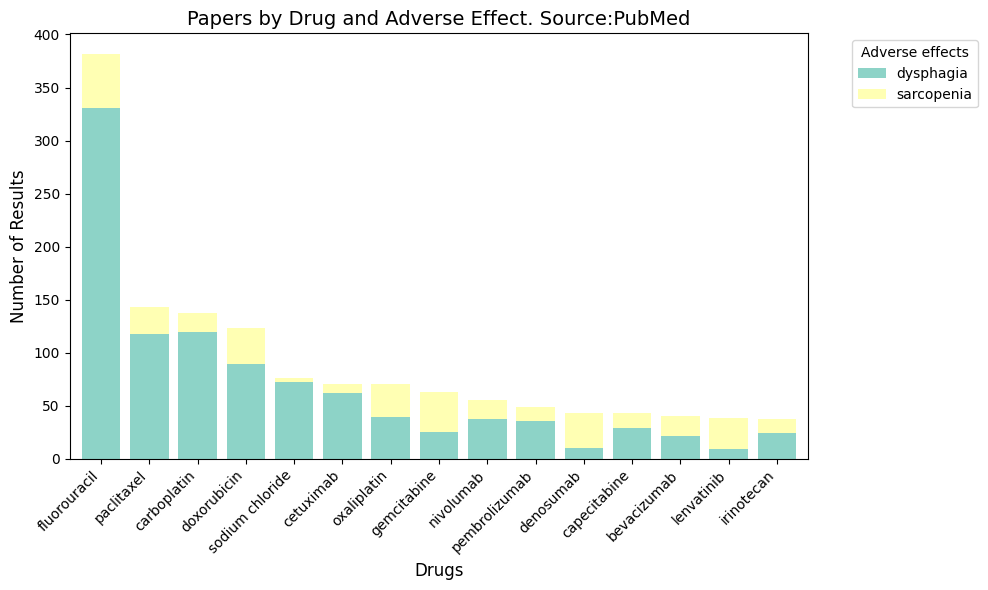

In [21]:
# Visualize the results of each drug in function of the adverse effect

bar_plot_results(results_df_wide, top_farmacos, num_columns = 15, xlab = 'Drugs', 
                     plot_title ='Papers by Drug and Adverse Effect. Source:PubMed', legend_title = 'Adverse effects')

In [ ]:
drugs = pd.read_csv("../data/drugs.csv")
tumors = pd.read_csv("../data/tumors.csv")

papers_results = iterative_pubmed_search_papers(tumors, drugs)
papers_results

In [ ]:
# Convert the object to a list
import json
# Convert the itertools.chain objects to lists
papers_results['results'] = papers_results['results'].apply(list)

# Convert the column "results" to JSON
df_json = papers_results['results'].to_json(orient='records', lines=True)

df_resultados = pd.read_json(df_json, orient='records', lines=True)

final_df = pd.DataFrame()
for record in df_resultados[0]:
    if record is not None and len(record) == len(df_resultados[0][0]):
        item = pd.DataFrame.from_records(record)
        final_df.append(item)

#df_resultados = pd.json_normalize(df_resultados)

final_df

In [55]:
df_resultados[0][1]

{'pubmed_id': '37735252\n31857949\n34233230\n33848354\n34388376\n34217295\n34298655\n34001994\n33941613\n33858423\n11922625\n33101773\n15897597\n28099142\n33009209\n34113619\n26183759\n30238280\n30370422\n34359819\n31527477\n30619741\n28535666\n34145929\n27464948\n28529316\n30055290\n31416916\n33671873',
 'title': 'Cancer/testis antigen CAGE mediates osimertinib resistance in non-small cell lung cancer cells and predicts poor prognosis in patients with pulmonary adenocarcinoma.',
 'abstract': 'CAGE, a cancer/testis antigen, was originally isolated from the sera of patients with gastric cancers. Previously, we have shown the role of CAGE in resistance to chemotherapy and target therapy. The aim of this study was to investigate the role of CAGE in osimertinib resistance and determine the prognostic value of CAGE in patients with pulmonary adenocarcinomas. The clinicopathological correlation with CAGE and autophagy flux in patients was examined using immunohistochemistry and in situ hybri

In [40]:
df_resultados.to_json('results.json', orient='records', lines=True)


In [25]:
# Load the JSON
json_obj = json.loads(df_json[0])

# Normalize the JSON and create the DataFrame
df = pd.json_normalize(json_obj)

# Print the DataFrame
print(df)

list

In [20]:
papers_results['results'] = papers_results['results'].apply(list)
papers_results['results'] 

0     [<pymed.article.PubMedArticle object at 0x0000...
1     [<pymed.article.PubMedArticle object at 0x0000...
2                                                    []
3     [<pymed.article.PubMedArticle object at 0x0000...
4     [<pymed.article.PubMedArticle object at 0x0000...
5     [<pymed.article.PubMedArticle object at 0x0000...
6     [<pymed.article.PubMedArticle object at 0x0000...
7     [<pymed.article.PubMedArticle object at 0x0000...
8     [<pymed.article.PubMedArticle object at 0x0000...
9                                                    []
10    [<pymed.article.PubMedArticle object at 0x0000...
11    [<pymed.article.PubMedArticle object at 0x0000...
12    [<pymed.article.PubMedArticle object at 0x0000...
13                                                   []
14                                                   []
15                                                   []
16    [<pymed.article.PubMedArticle object at 0x0000...
17                                              

In [16]:
papers_results['results']

0     <itertools.chain object at 0x00000286B1456FB0>
1     <itertools.chain object at 0x00000286B15B19C0>
2     <itertools.chain object at 0x00000286B15B1F30>
3     <itertools.chain object at 0x00000286B15B22F0>
4     <itertools.chain object at 0x00000286B15B2410>
5     <itertools.chain object at 0x00000286B15B2350>
6     <itertools.chain object at 0x00000286B15B1D50>
7     <itertools.chain object at 0x00000286B15B2500>
8     <itertools.chain object at 0x00000286B15B1DE0>
9     <itertools.chain object at 0x00000286B15B21D0>
10    <itertools.chain object at 0x00000286B15B1FF0>
11    <itertools.chain object at 0x00000286B15B1E40>
12    <itertools.chain object at 0x00000286B15B14E0>
13    <itertools.chain object at 0x00000286B15B2980>
14    <itertools.chain object at 0x00000286B15B2860>
15    <itertools.chain object at 0x00000286B15B2170>
16    <itertools.chain object at 0x00000286B15B2A40>
17    <itertools.chain object at 0x00000286B15B2680>
18    <itertools.chain object at 0x00000286B15